In [50]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP
from advectionGP.models import AdjointSecondOrderODEModel as Model #Model module builds basic parts of the ODE problem, combines other classes into full model

'''To use other models in the class, such as the Advection Diffusion Reaction model, 
replace "AdjointSecondOrderODEModel" in the line above with "AdjointAdvectionDiffusionReaction" model
and adjust parameters as appropriate'''

from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

In [51]:
avg=0.1 # time that an observation is taken for
tlocL = np.linspace(0,9.9,100) # observation start times
X500= np.zeros((len(tlocL),2)) # initiate X
# Build sensor locations
X500[:,0] = tlocL #lower time
X500[:,1] = X500[:,0]+avg # upper time

avg=0.1 # time that an observation is taken for
tlocL = np.linspace(0,9.9,10) # observation start times
X50= np.zeros((len(tlocL),2)) # initiate X
# Build sensor locations
X50[:,0] = tlocL #lower time
X50[:,1] = X50[:,0]+avg # upper time

sensors500 = FixedSensorModel(X500,0) # establish sensor model arguments are sensor locations and spatial averaging (not applicable in 1D case so set to 0)
sensors50 = FixedSensorModel(X50,0) # establish sensor model arguments are sensor locations and spatial averaging (not applicable in 1D case so set to 0)

In [52]:
k_0 = -0.5 #Diffusion coefficient
u=1
eta=5
noiseSD = 0.1 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0],[10])# edges of the grid - in units of time
kForward = EQ(np.sqrt(0.6), 4.0) # generate EQ kernel arguments are lengthscale and variance
res = [200] # grid size for time

In [53]:
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors500,k_0=k_0,u=u,eta=eta) #initiate PDE model to build concentration

dt,dt2,Nt = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=m.computeSourceFromPhi(z)# Compute ground truth source by approximating GP
#sourceGT = np.ones(m.resolution)  # Example constant source
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs ODE forward model
yTrain500= m.computeObservations(addNoise='TRUE') # Compute observations with noise uses m.sensormodel for observation locations

m.sensormodel=sensors50
yTrain50= m.computeObservations(addNoise='TRUE') # Compute observations with noise uses m.sensormodel for observation locations

Calculating Adjoints...
99/100 
Calculating Phis...
99/100 


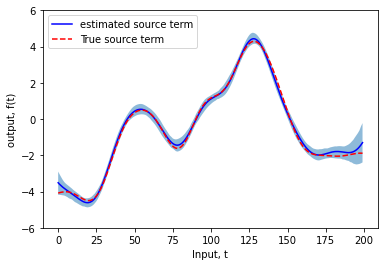

In [58]:
N_feat =100 #Number of features used to infer the source
kInverse = EQ(np.sqrt(0.6), 4) # Initiate kernel for inverse problem
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors500,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain500) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=m.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeConcentration(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
#plt.title("Source function ")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
plt.ylim((-6,6))
#plt.ylim([-5,5])
plt.savefig('500Sensors.pdf')
plt.show()


Calculating Adjoints...
9/10 
Calculating Phis...
99/100 


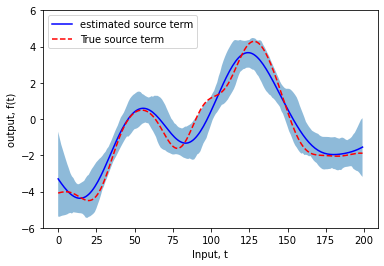

In [59]:
mInfer.sensormodel=sensors50
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain50) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=m.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeConcentration(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
#plt.title("Source function ")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
plt.ylim([-6,6])
plt.savefig('10Sensors.pdf')
plt.show()

Calculating Adjoints...
99/100 
Calculating Phis...
49/50 


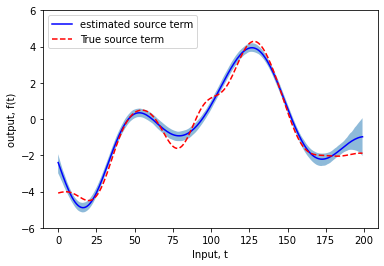

In [66]:
N_feat =10 #Number of features used to infer the source
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors500,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain500) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=m.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeConcentration(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
#plt.title("Source function ")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
plt.ylim((-6,6))
#plt.ylim([-5,5])
plt.savefig('10Features.pdf')
plt.show()


Calculating Adjoints...
99/100 
Calculating Phis...
99/100 


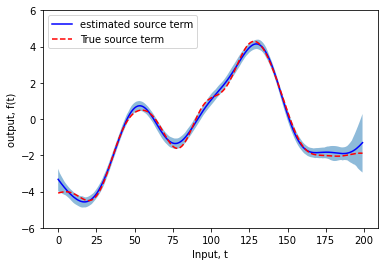

In [68]:
N_feat =100 #Number of features used to infer the source
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors500,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain500) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=m.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeConcentration(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
#plt.title("Source function ")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
plt.ylim((-6,6))
#plt.ylim([-5,5])
plt.savefig('100Features.pdf')
plt.show()